In [1]:
# import statements
import numpy as np
import xarray as xr
import glob
import random
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
import sys
import matplotlib.pyplot as plt
import TestingTrainingSplit_CV
from matplotlib.colors import LinearSegmentedColormap


# Get names of models in which we are testing on
path_to_data = '/home/disk/pna2/aodhan/SurfaceTrendLearning/PoChedleyEtAl2022/TASsplicedmaps/*_TrendMaps.nc'
ModelNames = [i[70:-16] for i in glob.glob(path_to_data)]

# Get observational data
#observational_trends = glob.glob('/home/disk/p/aodhan/SurfaceTrendLearing/TropicalTASApplication/TASObsTrends/*.npy')
#observational_trend_maps = [np.load(observational_trends[i]) for i in range(0,len(observational_trends))]
#latitudes = np.linspace(-88.75,88.75,72)
#weights = np.cos(np.deg2rad(latitudes)) # these will be used to weight predictors
#observational_trend_maps_weighted = np.multiply(observational_trend_maps, weights[np.newaxis,:,np.newaxis])
#observational_trend_maps_reshaped = np.reshape(observational_trend_maps_weighted, (3, 72*144))

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

# Do CV train-test-split 
TrainingPredictorData, TrainingTargetData, TestingPredictorData, TestingTargetData, TestingTotalTrend = TestingTrainingSplit_CV.training_testing_split(path_to_data)


In [2]:
from keras.models import Sequential
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from tensorflow.keras import datasets, layers, models, optimizers
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler

#tf.random.set_seed(0)

# iterate over all CV folds (there should be eqaul number of CV folds as models)
NameValidatationPredictions = []
gistemp_predictions = []
era5_predictions = []
hadcrut_predictions = []

#for param_set in conv_params:
predictions = []
validations = []

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=4e-5, restore_best_weights=True)

for model_idx in range(len(ModelNames)):
    
    # reshape predictor data
    TrainingTargetDataShape = np.shape(TrainingTargetData[model_idx])
    TestinTargetDataShape = np.shape(TestingTargetData[model_idx])

    TrainingPredictorTimePeriod = np.reshape(TrainingPredictorData[model_idx], (int(len(TrainingPredictorData[model_idx])/26), 26, 72*144))
    TrainingTargetTimePeriod = np.reshape(TrainingTargetData[model_idx], (int(len(TrainingPredictorData[model_idx])/26), 26, 2, 3))

    
    X_train = TrainingPredictorTimePeriod[:,:,:]
    X_train = np.reshape(X_train, (len(X_train)*26,72*144))
    Y_train = TrainingTargetTimePeriod[:,:,:,:]
    Y_train = np.reshape(Y_train, (len(Y_train)*26,2,3))
    Y_train = Y_train[:,:,0]#[:,1]
    
    X_val = TrainingPredictorTimePeriod[:,-1,:]
    Y_val = TrainingTargetTimePeriod[:,-1,:,:]
    Y_val = Y_val[:,:,0]#[:,1]


    X_test = TestingPredictorData[model_idx]
    Y_test = TestingTargetData[model_idx]
    Y_test = Y_test[:,:,0]#[:,1]

    # scale all data
    t = MinMaxScaler()
    t.fit(X_train)
    X_train_scaled = t.transform(X_train)
    X_train_scaled = np.reshape(X_train_scaled, (len(X_train_scaled), 72,144,1))
    X_val_scaled = t.transform(X_val)
    X_val_scaled = np.reshape(X_val_scaled, (len(X_val_scaled), 72,144,1))
    X_test_scaled = t.transform(X_test)
    X_test_scaled = np.reshape(X_test_scaled, (len(X_test_scaled), 72,144,1))

    # model design
    num_filters_1 = 128
    num_filters_2 = 128
    num_filters_3 = 32
    filter_size_1 = 3
    pool_size = 3

    model = models.Sequential()
    model.add(layers.Conv2D(256, 3, activation='relu',  input_shape=(72, 144, 1)))
    model.add(layers.MaxPooling2D(pool_size))
    model.add(layers.Flatten())
    model.add(layers.Dense(2))
    model.compile(loss="mse", optimizer=optimizers.Adam(learning_rate=1e-4))
    model.fit(X_train_scaled, Y_train, epochs=100, verbose=1, validation_split=0.1, callbacks=[stop_early])
    
    # Predict using trained model
    Y_pred = model.predict(X_test_scaled)

    model.save("/home/disk/p/aodhan/SurfaceTrendLearing/TropicalTASApplicationSpliced/output/256_3_MP3_{modelname}.h5".format(modelname=ModelNames[model_idx]))
    
    # Apply trained model to observations
    #Y_pred_Gistemp = model.predict(observational_trend_maps_reshaped[0].reshape(1, -1))
    #Y_pred_ERA5 = model.predict(observational_trend_maps_reshaped[1].reshape(1, -1))
    #Y_pred_HadCrut = model.predict(observational_trend_maps_reshaped[2].reshape(1, -1))
    
    # Save output for plotting
    NameValidatationPredictions.append([ModelNames[model_idx], Y_test, Y_pred])
    #gistemp_predictions.append(Y_pred_Gistemp)
    #era5_predictions.append(Y_pred_ERA5)
    #hadcrut_predictions.append(Y_pred_HadCrut)
    validations.append(Y_test)
    predictions.append(Y_pred)
    print(ModelNames[model_idx])
    print(stats.pearsonr(Y_test[:,0], Y_pred[:,0]))
    print(np.nanmean(np.square((Y_test[:,0] - Y_pred[:,0]))))
    print(np.nanmean(np.square((Y_test[:,1] - Y_pred[:,1]))))
    #print(np.nanmean(np.abs((Y_test[:,1] - Y_pred[:,1]))))

2023-02-09 06:40:17.223572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 06:40:51.123700: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 06:40:51.125443: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/100
 23/128 [====>.........................] - ETA: 31s - loss: 0.0436

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykern

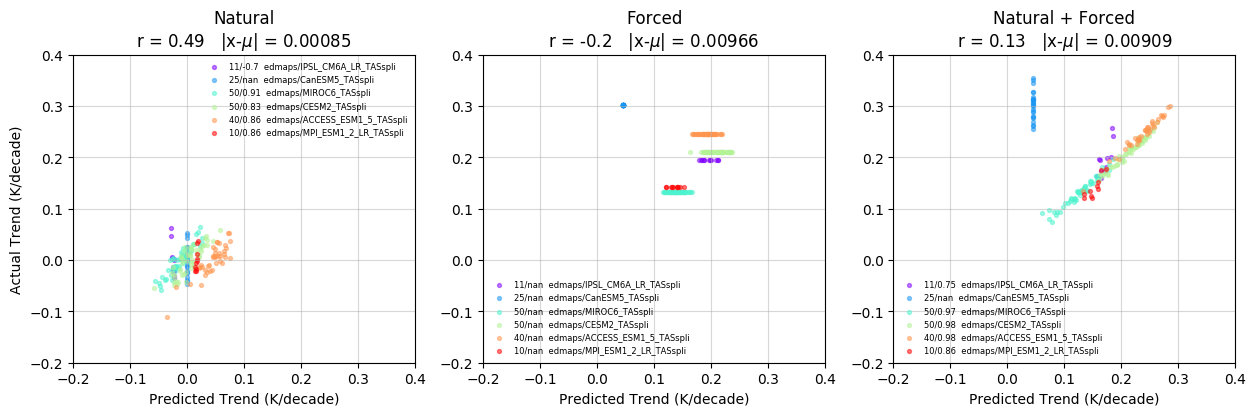

In [13]:
# Scaled CONV2d(128,3,64,2,32,2 maxpooling(3), dense(2)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 6))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []

    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,1]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.square((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:7])

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykern

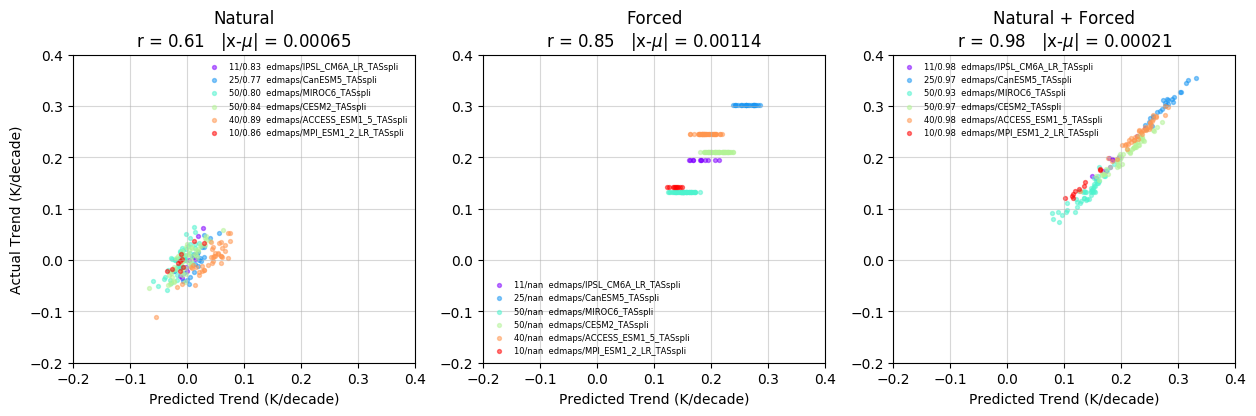

In [10]:
# Scaled CONV2d(128,3,64,2,32,2 maxpooling(3), dense(2)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 6))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []

    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,1]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.square((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:7])

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykern

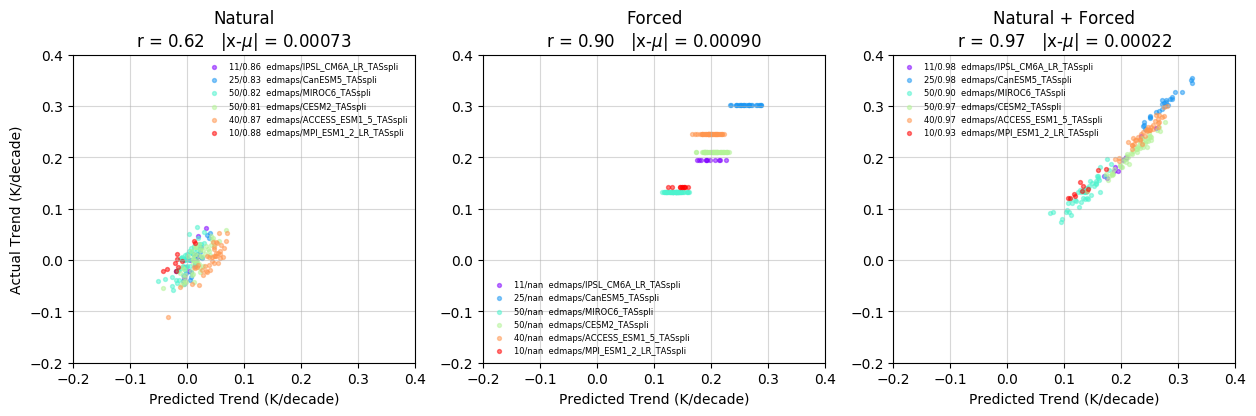

In [8]:
# Scaled CONV2d(128,3,64,2,32,2 maxpooling(3), dense(2)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 6))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []

    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,1]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.square((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:7])

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

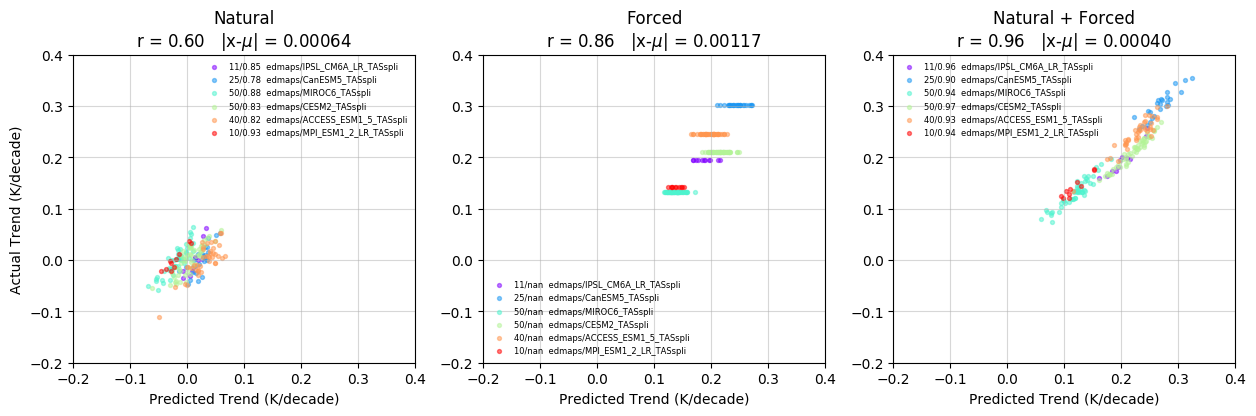

In [6]:
# Scaled CONV2d(128,3, maxpooling(3), dense(2))
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 6))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []

    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,1]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.square((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:7])

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

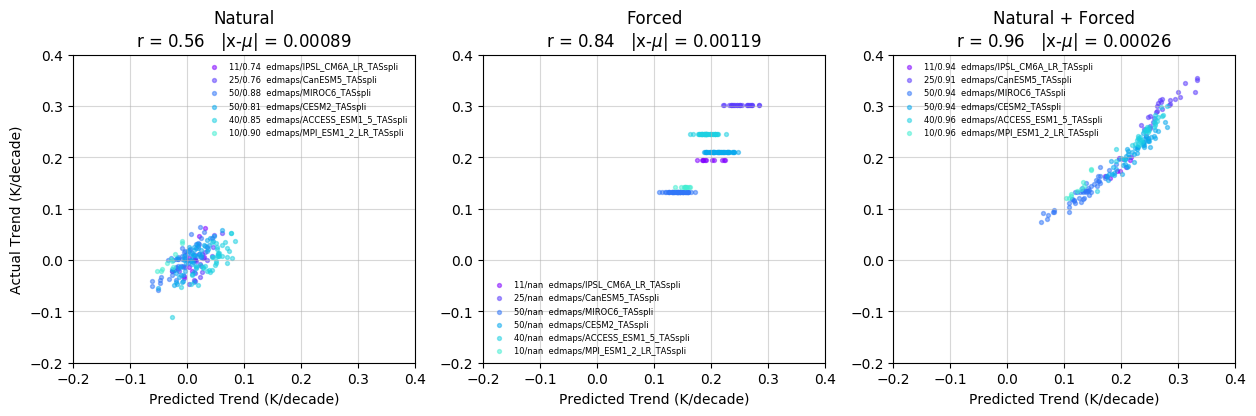

In [14]:
# Scaled CONV2d(128,3)  maxpooling(3), dense(2)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 14))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []
    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,3]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.square((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:7])

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykern

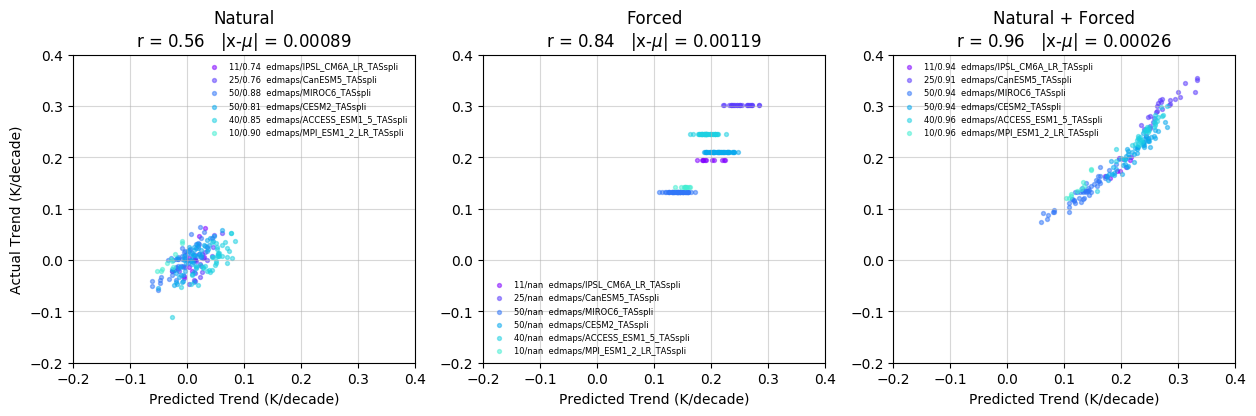

In [13]:
# Scaled CONV2d(128,3)  maxpooling(3), dense(2)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 14))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []
    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,3]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.square((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:7])

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykern

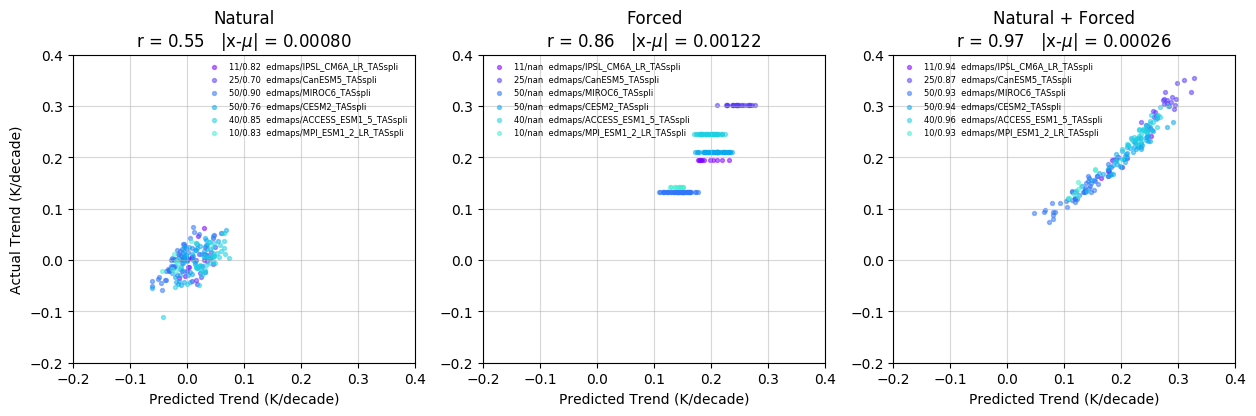

In [11]:
# Scaled CONV2d(128,3, padding='same')  maxpooling(3), dense(2)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 14))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []
    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,3]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.square((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:7])

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykern

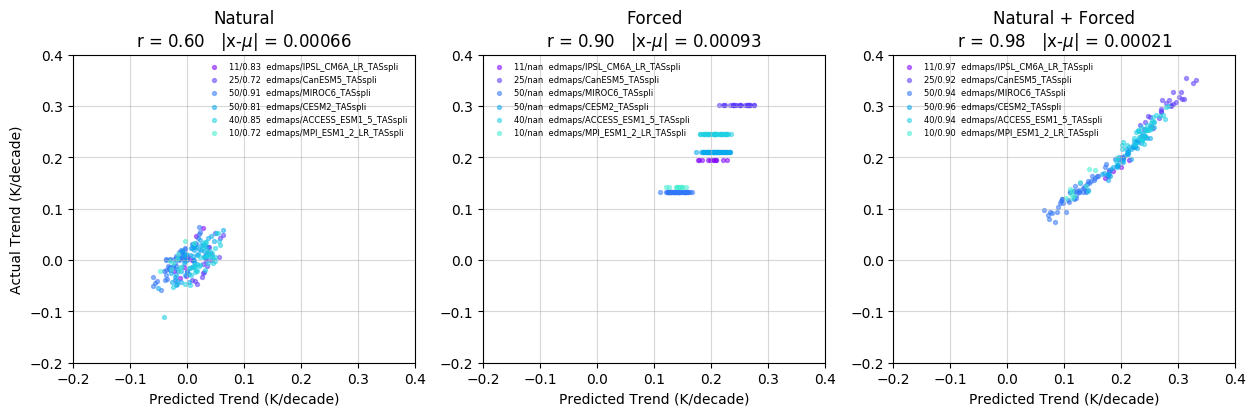

In [9]:
# Scaled CONV2d(144,3)  maxpooling(3), dense(2)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 14))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []
    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,3]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.square((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:7])

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykern

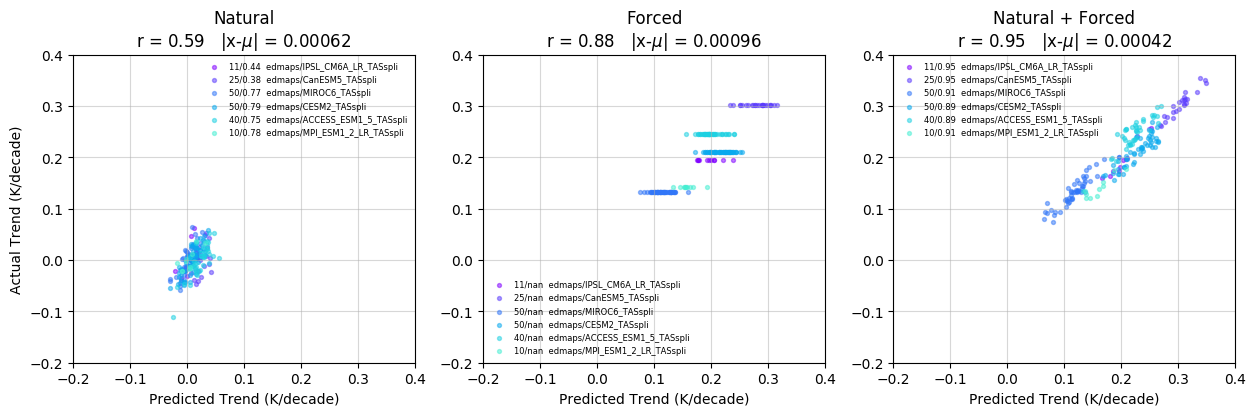

In [7]:
# Scaled CONV2d(64,3)  maxpooling(3), CONV2d(64,3)  maxpooling(3), CONV2d(64,3)  maxpooling(3), dense(2)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 14))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []
    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,3]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.square((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:7])

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykern

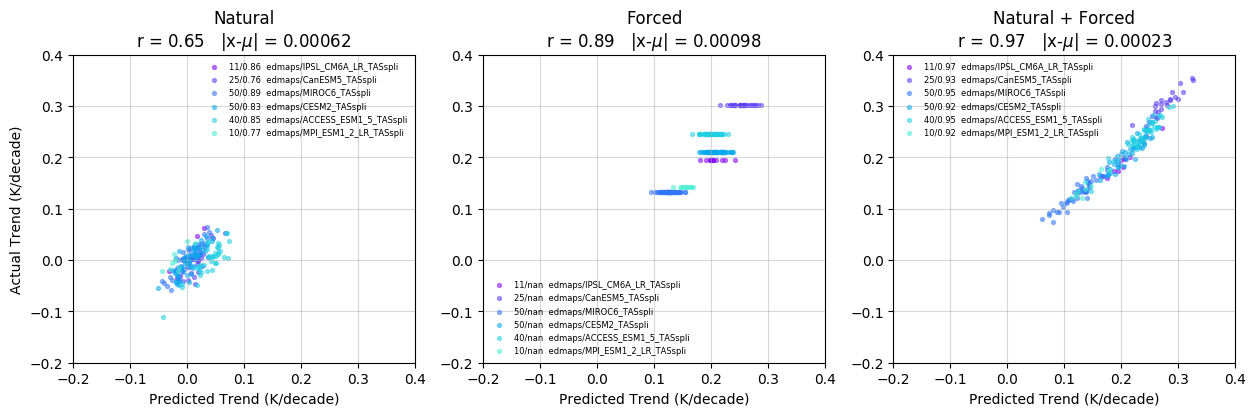

In [5]:
# Scaled CONV2d(128,3)  maxpooling(3), dense(2)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 14))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []
    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,3]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.square((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:7])

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykern

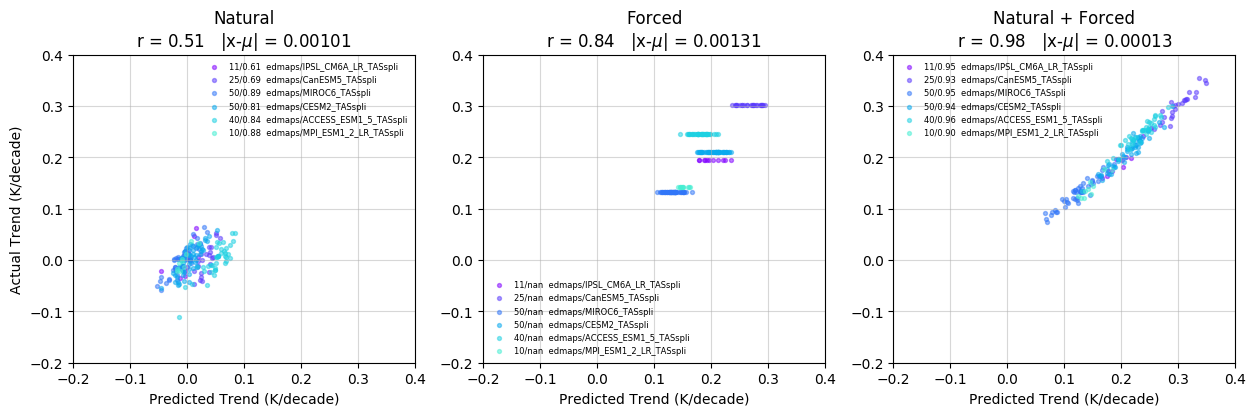

In [3]:
# Scaled CONV2d(72,3)  maxpooling(3), CONV2d(72,3)  maxpooling(3), dense(2)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 14))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []
    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,3]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.square((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:7])

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

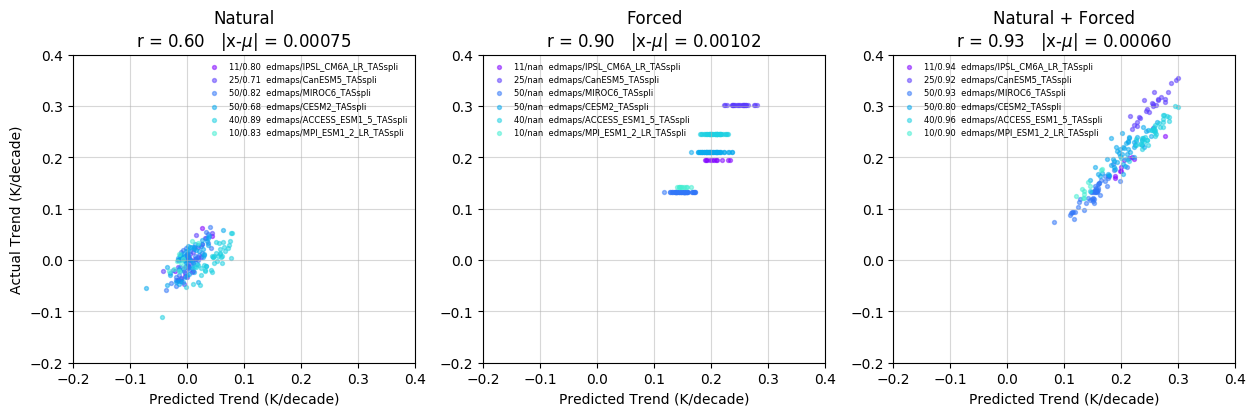

In [5]:
# Scaled CONV2d(72,3)  maxpooling(3), dense(2)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 14))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []
    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,3]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.square((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:7])

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

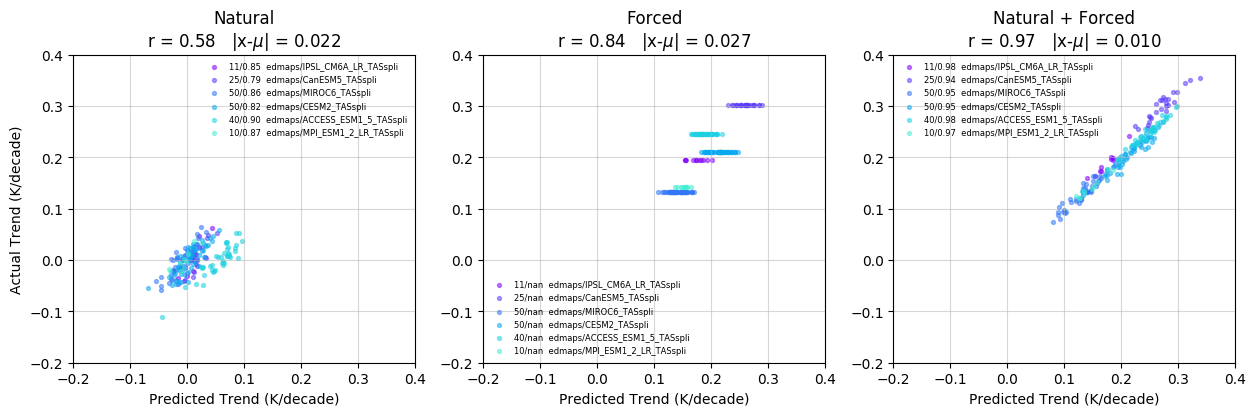

In [5]:
# CONV2d(72,3)  maxpooling(3), dense(2)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 14))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []
    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,3]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.abs((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:5])

In [36]:
training_data_again = np.reshape(TrainingPredictorData[0], (int(len(TrainingPredictorData[0])/26), 26, 72*144))

print(np.shape(training_data_again))

(175, 26, 10368)


In [34]:
len(TrainingPredictorData[5])/26

176.0

In [21]:
4550/26

175.0